<a href="https://colab.research.google.com/github/hhk54250/Is20f/blob/master/haokai/CGMY-FFT%20and%20calibration2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from scipy.integrate import quad
import math
from scipy import optimize

import pandas as pd

In [2]:

class FTCall:
    def __init__(self, model):
        self.md = model
        
    #$\psi$ function for carr-madan method
    def psi(self, w, T, alpha):
        o1 = np.exp(-self.md.r*T)
        o1 = o1*self.md.charfun(T, w - (alpha+1)*1j)
        o2 = alpha**2+alpha-w**2+1j*(2*alpha+1.)*w
        return o1/o2
    
    #carr-madan method with damping
    def price_cm(self, K, T, alpha = 1.5):
        k = np.log(K)
        integrand = lambda w: (np.exp(-1j*w*k)*self.psi(w, T, alpha)).real
        integral = quad(integrand, 0, np.inf)[0]
        return np.exp(-alpha*k)/np.pi*integral

In [3]:
class Heston:
    def __init__(self, S0, v0, r, kappa, theta, xi, rho):
        self.S0 = S0
        self.v0 = v0
        self.r = r
        self.kappa = kappa
        self.theta = theta
        self.xi = xi
        self.rho = rho
        
    #char func for ln(S_T) from Ng05
    def charfun(self, T, u):
        t1 = self.kappa - self.rho*self.xi*1j*u
        D = np.sqrt(t1**2+(u**2+1j*u)*self.xi**2)
        G = (t1-D)/(t1+D)
        t2 = 1-G*np.exp(-D*T)
        f1 = np.exp(1j*u*(np.log(self.S0+self.r*T)))
        f2 = np.exp(self.v0*(1-np.exp(-D*T))*(t1-D)/self.xi**2/t2)
        f3 = np.exp(self.kappa*self.theta*(
            T*(t1-D)-2*np.log(t2/(1-G)))/self.xi**2)
        return f1*f2*f3

In [4]:
hes = Heston(100, 0.04, 0.03, 2, 0.04, 0.5, -0.7)
ftc = FTCall(hes)
ans = ftc.price_cm(100, 0.5, alpha = 1.5)
print(
      f'Heston FT price by carr-madan is \n  >> {ans}'
      )
print('(ref. P61 of [Hirsa13])')

Heston FT price by carr-madan is 
  >> 5.112752678867938
(ref. P61 of [Hirsa13])


In [5]:
T = 10
#risk free rate
r = 0
#long term volatility(equiribrium level)
theta = 0.0398
#Mean reversion speed of volatility
kappa = 1.5768
#sigma(volatility of Volatility)
sigma = 0.5751
#rho
rho = -0.5751
#Initial stock price
S0 = 100
#Initial volatility
v0 = 0.0175
def charfun(u):
    T = 10
    #risk free rate
    r = 0
    #long term volatility(equiribrium level)
    theta = 0.0398
    #Mean reversion speed of volatility
    kappa = 1.5768
    #sigma(volatility of Volatility)
    xi = 0.5751
    #rho
    rho = -0.5751
    #Initial stock price
    S0 = 100
    #Initial volatility
    v0 = 0.0175
    t1 = kappa - rho*xi*1j*u
    D = np.sqrt(t1**2+(u**2+1j*u)*xi**2)
    G = (t1-D)/(t1+D)
    t2 = 1-G*np.exp(-D*T)
    f1 = np.exp(1j*u*(np.log(S0+r*T)))
    f2 = np.exp(v0*(1-np.exp(-D*T))*(t1-D)/xi**2/t2)
    f3 = np.exp(kappa*theta*(
        T*(t1-D)-2*np.log(t2/(1-G)))/xi**2)
    return f1*f2*f3
def SimpsonW(N,eta):
    delt = np.zeros(N, dtype=np.float)
    delt[0] = 1
    j = np.arange(1, N + 1, 1)
    SimpsonW = eta*(3 + (-1) ** j - delt) / 3
    return SimpsonW
    
def psi(w, T, alpha, r):
    o1 = np.exp(-r*T)
    o1 = o1*charfun(w - (alpha+1)*1j)
    o2 = alpha**2+alpha-w**2+1j*(2*alpha+1.)*w
    return o1/o2

def Heston_NumpyFFT(S0, K, T):
    k = np.log(K)
    x0 = np.log(S0)
    N =2**10
    alpha=1.5
    
    eta=0.15
    lambda_ = 2 * np.pi / (N *eta)
    beta=x0-lambda_*N/2
    km=np.asarray([beta+i*lambda_ for i in range(N)])
    W=SimpsonW(N,eta)
    v=np.asarray([i*eta for i in range(N)])
    Psi=np.asarray([psi(vj, T, alpha, 0)  for vj in v])
    FFTFunc=Psi*np.exp(-1j*beta*v)*W
    
    
    y=np.fft.fft(FFTFunc).real
    
    
    cT=np.exp(-alpha*km)*y/np.pi
    return cT
Heston_NumpyFFT(100, 80, 10)[514]

18.791154357043478

In [6]:
S0 = 100.0  # index level
N =2**10 
eta=0.15
lambda_ = 2 * np.pi / (N *eta)
x0 = np.log(S0)
beta=x0-lambda_*N/2
k=np.asarray([np.e**(beta+lambda_*n) for n in range(N)])


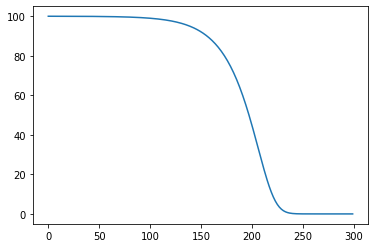

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


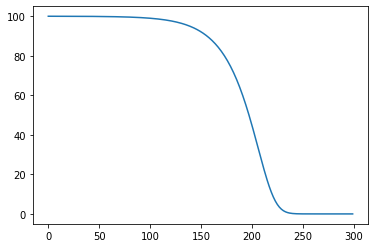

In [7]:
import matplotlib.pyplot as plt
plt.plot(Heston_NumpyFFT(100, 80, 10)[300:600]) 
plt.show()  
hes = Heston(100, 0.0175, 0., 1.5768, 0.0398, 0.5751, -0.5751)
ftc = FTCall(hes)
t=[]
for i in range(300,600):
  t.append(ftc.price_cm(k[i], 10, alpha = 1.5))
plt.plot(t) 
plt.show() 


In [8]:
class FFTCall:
    def __init__(self, model):
        self.md = model
    def psi(self, w, T, alpha):
        o1 = np.exp(-self.md.r*T)
        o1 = o1*self.md.charfun(T, w - (alpha+1)*1j)
        o2 = alpha**2+alpha-w**2+1j*(2*alpha+1.)*w
        return o1/o2
    def SimpsonW(self, N, eta):
        delt = np.zeros(N, dtype=np.float)
        delt[0] = 1
        j = np.arange(1, N + 1, 1)
        SimpsonW = eta*(3 + (-1) ** j - delt) / 3
        return SimpsonW
    def Heston_NumpyFFT(self, T, N, eta, alpha):
        x0 = np.log(self.md.S0)
        lambda_ = 2 * np.pi / (N *eta)
        beta=x0-lambda_*N/2
        km=np.asarray([beta+i*lambda_ for i in range(N)])
        W=self.SimpsonW(N,eta)
        v=np.asarray([i*eta for i in range(N)])
        Psi=np.asarray([self.psi(vj, T, alpha)  for vj in v])
        FFTFunc=Psi*np.exp(-1j*beta*v)*W
        y=np.fft.fft(FFTFunc).real   
        cT=np.exp(-alpha*km)*y/np.pi
        return cT    

In [9]:
class Heston1:
    def __init__(self, S0, v0, r, kappa, theta, xi, rho):
        self.S0 = S0
        self.v0 = v0
        self.r = r
        self.kappa = kappa
        self.theta = theta
        self.xi = xi
        self.rho = rho
    #char func for ln(S_T) from Ng05
    def charfun(self, T, u):
        t1 = self.kappa - self.rho*self.xi*1j*u
        D = np.sqrt(t1**2+(u**2+1j*u)*self.xi**2)
        G = (t1-D)/(t1+D)
        t2 = 1-G*np.exp(-D*T)
        f1 = np.exp(1j*u*(np.log(self.S0+self.r*T)))
        f2 = np.exp(self.v0*(1-np.exp(-D*T))*(t1-D)/self.xi**2/t2)
        f3 = np.exp(self.kappa*self.theta*(
            T*(t1-D)-2*np.log(t2/(1-G)))/self.xi**2)
        return f1*f2*f3

hes = Heston1(100, 0.0175, 0., 1.5768, 0.0398, 0.5751, -0.5751)
fttc = FFTCall(hes)
ans = fttc.Heston_NumpyFFT(10, 2**10, 0.15, alpha = 1.5)
ans[514]
hes = Heston(100, 0.0175, 0., 1.5768, 0.0398, 0.5751, -0.5751)
ftc = FTCall(hes)
t=[]

In [10]:
#speed test


%%time
for i in range(1023):
  t.append(ftc.price_cm(k[i], 10, alpha = 1.5))
t

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


CPU times: user 29.1 s, sys: 7.11 ms, total: 29.1 s
Wall time: 29.1 s


In [11]:
%%time
fttc.Heston_NumpyFFT(10, 2**10, 0.15, alpha = 1.5)

CPU times: user 30.5 ms, sys: 5 µs, total: 30.5 ms
Wall time: 31.7 ms


array([-3.27450836e+14, -3.01260253e+14, -2.75800941e+14, ...,
       -2.11086972e-13, -1.96805178e-13, -1.82721879e-13])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  # This is added back by InteractiveShellApp.init_path()


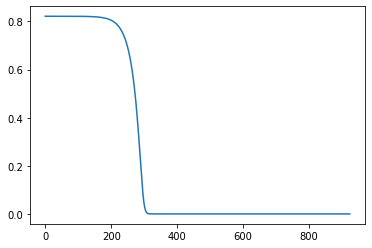

In [12]:
class CGMY:
    def __init__(self, S0, G, Y, C, M, r):
        self.S0 = S0
        self.G = G
        self.Y = Y
        self.C = C
        self.M = M
        self.r = r
    def charfun(self, T, u):
        integrand = lambda w: w**(-(self.Y)-1)*(np.e)**(-w)
        gamma = quad(integrand, 0, np.inf)[0]
        f1 = (np.e)**(self.C*T*gamma*((self.M-1j*u)**self.Y-self.M**self.Y+(self.G+1j*u)**self.Y-self.G**self.Y))
        return f1

CGMY = CGMY(100,5,0.5,2,10,0.03)
ftt2 = FFTCall(CGMY)
ans2 = ftt2.Heston_NumpyFFT(0.5, 2**10, 0.15, alpha = 0.5)

plt.plot(ans2[100:1024]) 
plt.show()  

In [13]:
class CGMY2:
    def __init__(self, S0, G, Y, C, M, r):
        self.S0 = S0
        self.G = G
        self.Y = Y
        self.C = C
        self.M = M
        self.r = r
    def charfun(self, T, u):
        gamma = math.gamma(-(self.Y))
        beta = self.C*(self.G**self.Y)*gamma*((1+1/self.G)**self.Y-1-self.Y/self.G) + self.C*(self.M**self.Y)*gamma*((1-1/self.M)**self.Y-1+self.Y/self.M)
        f1 = (np.e)**(1j*u*np.log(self.S0)+(self.r-beta)*T)
        f2 = (np.e)**(self.C*(self.G**self.Y)*T*gamma*((1+1j*u/self.G)**self.Y-1-1j*u*self.Y/self.G) + self.C*(self.M**self.Y)*T*gamma*((1-1j*u/self.M)**self.Y-1+1j*u*self.Y/self.M))
        return f1*f2

In [14]:
CGMY = CGMY2(100,5,0.5,2,10,0.03)
ftt1 = FFTCall(CGMY)
ans1 = ftt1.Heston_NumpyFFT(0.5, 2**10, 0.15, alpha = 0.5)

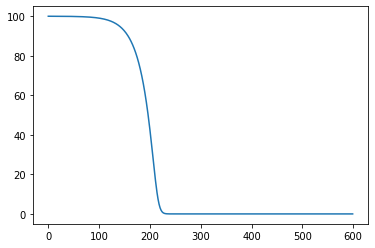

10.725567345057915

In [15]:
plt.plot(ans1[300:900]) 
plt.show()  
ans1[514]

In [16]:
ftc1 = FTCall(CGMY)
ans = ftc1.price_cm(40, 0.5, alpha = 1.5)
ans


62.049226774184774

In [17]:


market_price = 62.049226774184774

def g(params):
    C,G,M,Y,r = params
    market_price = 62.049226774184774
    CGMY = CGMY2(100,M,Y,C,G,r)
    ftc1 = FTCall(CGMY)
    ans = ftc1.price_cm(40, 0.5, alpha = 1.5)
    return abs(market_price - ans)

guess_g=[1,5,2,0.1,0.01]

minimum2= optimize.fmin(g,guess_g,maxfun=400000000000,maxiter=400000000000,ftol=1e-50,xtol=1e-12)

minimum2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 237
         Function evaluations: 510


array([0.85274671, 5.3672713 , 2.17504803, 0.10000157, 0.01026715])

In [18]:
CGMY = CGMY2(100,2.17504803,0.10000157,0.85274671,5.3672713,0.01026715)
ftc1 = FTCall(CGMY)
ans = ftc1.price_cm(40, 0.5, alpha = 1.5)
ans

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


62.04922676390341

In [19]:
%cd~

!git clone https://github.com/hhk54250/IS20.git 
pass

/root
fatal: destination path 'IS20' already exists and is not an empty directory.


In [20]:
%cd IS20
%ls

/root/IS20
'analytical solution of Heston model.ipynb'
'CGMY and implied CGMYr.ipynb'
'data(1).csv'
 Fourier_Transform_Heston_BSM.ipynb
 Heston-FFT2.ipynb
 Heston-FFT.ipynb
'Option value using fast fourier transform.ipynb'
'Option value using fast fourier transform(last version).ipynb'
 README.md
 Untitled13.ipynb


In [21]:
market = pd.read_csv("option.csv")
market_strike = market['1']


FileNotFoundError: ignored

In [ ]:
market